In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
orders = pd.read_csv('../data/full_data.csv')

In [3]:
orders.head()

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,9.0,Regular Coffee,NaN,'coffe':2 'regular':1,Drink
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,485.0,Kashk Bademjan,"Barbequed eggplant, lentils, fried onions, gar...",'bademjan':2 'bbq':8 'egg':10 'eggplant':6 'ga...,Main


In [4]:
orders.columns = [c.lower() for c in orders.columns]
orders.columns

Index(['orderid', 'userid', 'restaurantid', 'date', 'rating', 'comments',
       'address', 'count', 'itemid', 'price', 'viewcount', 'name',
       'description', 'searchvector', 'type'],
      dtype='object')

In [5]:
data = orders[['orderid', 'userid', 'date', 'rating','itemid']]

In [6]:
data.head()

,orderid,userid,date,rating,itemid
0,8,113,2020-03-28 08:15:25.615002,NaN,211
1,8,113,2020-03-28 08:15:25.615002,NaN,218
2,293,4,2020-05-13 01:20:59.267256,NaN,440
3,294,3,2020-05-13 17:34:35.519326,NaN,455
4,297,142,2020-05-14 00:08:48.756423,NaN,540


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24109 entries, 0 to 24108
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   orderid  24109 non-null  int64  
 1   userid   24109 non-null  int64  
 2   date     24109 non-null  object 
 3   rating   1757 non-null   float64
 4   itemid   24109 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 941.9+ KB


In [8]:
data.nunique()

orderid    10868
userid      4539
date       10868
rating         5
itemid       359
dtype: int64

In [9]:
data = data[~(data['rating'].isna())].reset_index()

In [10]:
data.head()

,index,orderid,userid,date,rating,itemid
0,2229,1794,466,2020-09-02 19:58:44.437661,5.0,437
1,2238,1800,537,2020-09-03 00:06:38.153495,5.0,82653
2,2239,1800,537,2020-09-03 00:06:38.153495,5.0,81575
3,2245,1805,510,2020-09-03 01:44:22.927765,3.0,82653
4,2246,1805,510,2020-09-03 01:44:22.927765,3.0,82659


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    1757 non-null   int64  
 1   orderid  1757 non-null   int64  
 2   userid   1757 non-null   int64  
 3   date     1757 non-null   object 
 4   rating   1757 non-null   float64
 5   itemid   1757 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 82.5+ KB


In [12]:
split_value = int(len(data) * 0.80)
train_data = data[:split_value]
test_data = data[split_value:]

/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_87904/3755396028.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


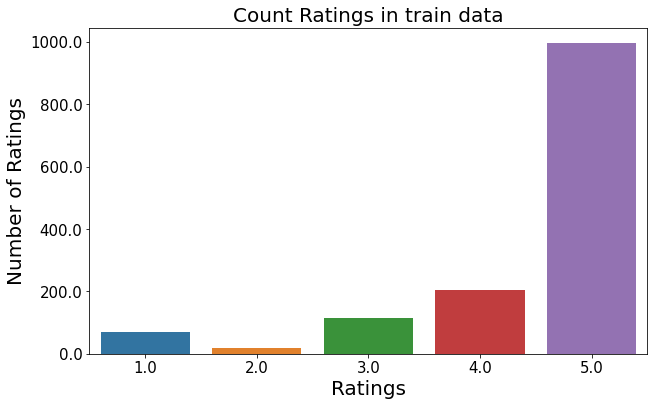

In [13]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [14]:
no_rated_item_per_user = train_data.groupby(by = "userid")["rating"].count().sort_values(ascending = False)
no_rated_item_per_user.head(10)

userid
814     15
818     12
1196    12
2684    11
2998    10
2644    10
1542     9
2648     9
2093     9
1226     9
Name: rating, dtype: int64

In [15]:
no_ratings_per_movie = train_data.groupby(by = "itemid")["rating"].count().sort_values(ascending = False)
no_ratings_per_movie.head(10)

itemid
82659    129
81555     67
81558     66
81553     64
82674     57
82676     45
82942     42
81554     38
523       29
82939     28
Name: rating, dtype: int64

In [16]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.userid, df.itemid)))
    return sparse_data

In [17]:
train_sparse_data = get_user_item_sparse_matrix(train_data)
train_sparse_data

<3317x83092 sparse matrix of type '<class 'numpy.float64'>'
	with 1329 stored elements in Compressed Sparse Row format>

In [18]:
test_sparse_data = get_user_item_sparse_matrix(test_data)
test_sparse_data

<4866x83448 sparse matrix of type '<class 'numpy.float64'>'
	with 343 stored elements in Compressed Sparse Row format>

In [19]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))


Global Average Rating: 4.702784048156508


In [20]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings


In [21]:
average_rating_user = get_average_rating(train_sparse_data, True)


In [22]:
avg_rating_item = get_average_rating(train_sparse_data, False)


In [23]:
total_users = len(np.unique(data["userid"]))
train_users = len(np.unique(train_data["userid"]))
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 630
No. of Users in train data= 521
No. of Users not present in train data = 109(17.0%)


In [24]:
total_items = len(np.unique(data["itemid"]))
train_items = len(avg_rating_item)
uncommonItems = total_items - train_items
                  
print("Total no. of Items = {}".format(total_items))
print("No. of Items in train data= {}".format(train_items))
print("No. of Items not present in train data = {}({}%)".format(uncommonItems, np.round((uncommonItems/total_items)*100), 2))


Total no. of Items = 192
No. of Items in train data= 178
No. of Items not present in train data = 14(7.0%)


In [25]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(331600).reshape(3316,100)

    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
        

    return similar_arr

similar_user_matrix = compute_user_similarity(train_sparse_data)

similar_user_matrix[10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
items = pd.read_csv('../data/itemsInfo.csv')

/Users/nakisaabbasi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
items.columns = [c.lower() for c in items.columns]
items.columns 

Index(['id', 'name', 'description', 'photourl', 'tagsstring', 'rating',
       'ratingcount', 'calories', 'fiber', 'carbohydrate', 'searchvector',
       'isglobal', 'property', 'sku', 'type'],
      dtype='object')

In [28]:
items = items[~(items.description.duplicated() & items.name)].reset_index()

In [29]:
items = items[['id','name','description']]

In [30]:
items.set_index('id')

,name,description
id,,
81465,Popina Bottled Water,NaN
81456,"Mayhem, Pinot Gris (bottle)",750 ML
81439,Grass Fed BC Double Cheeseburger (8oz),8 oz grass-fed BC beef caramelized on flat top...
81440,Crispy Free Run Chicken Sandwich,8oz boneless chicken leg marinated in buttermi...
81438,Grass Fed Bc Beef Cheesburger (4oz),4 oz grass-fed BC beef caramelized on flat top...
...,...,...
82543,Gin & Tonic,Gin & Tonic 1oz
82544,Gin & Soda,Gin & Soda 1oz
82523,Pacific North West Roll,Dungeness crab.avocado inside on top is scallp...


In [31]:
def compute_item_similarity_count(sparse_matrix, item_titles_df, item_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = item_titles_df.loc[item_id][1], similarity[item_id].count_nonzero()
    return no_of_similar_movies

In [32]:
similar_items = compute_item_similarity_count(train_sparse_data, items, 1000)
print("Similar Items = {}".format(similar_items))

Similar Items = ("S'mores Chocolate Cheesecake", 0)


In [33]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_items):
    users, items, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_items = np.unique(items)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    item = np.random.choice(uniq_items, no_of_items, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(items, item))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], items[mask])), 
                                                     shape = (max(user)+1, max(item)+1))
    return sparse_matrix

In [34]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

In [35]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 100, 20)

In [49]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_items= get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_items, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("../data/new_features.csv", mode = "w")
    
    for user, item, rating in zip(sample_train_users, sample_train_items, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(item)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, item].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[item]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_items = cosine_similarity(sample_sparse_matrix[:,item].T, sample_sparse_matrix.T).ravel()
        similar_items_indices = np.argsort(-similar_items)[1:]
        similar_items_ratings = sample_sparse_matrix[user, similar_items_indices].toarray().ravel()
        top_similar_item_ratings = list(similar_items_ratings[similar_items_ratings != 0][:5])
        top_similar_item_ratings.extend([global_avg_users[user]] * (5-len(top_similar_item_ratings)))
        similar_arr.extend(top_similar_item_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_items[item])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('../data/new_features.csv', names = ["user_id", "item_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_item_rating1", "similar_item_rating2", 
                                                               "similar_item_rating3", "similar_item_rating4", 
                                                               "similar_item_rating5", "user_average", 
                                                               "item_average", "rating"])
    return new_features_df
            

In [50]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [38]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,item_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_item_rating1,similar_item_rating2,similar_item_rating3,similar_item_rating4,similar_item_rating5,user_average,item_average,rating
0,2619,418,4.459016,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.000,0.0
1,2619,419,4.459016,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.000,0.0
2,363,431,4.459016,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.625,5.0
3,1007,431,4.459016,5.0,4.0,4.0,5.0,5.0,5.0,4.5,4.5,4.5,4.5,4.5,4.625,4.0
4,1401,431,4.459016,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.625,5.0


In [39]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [40]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,item_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_item_rating1,similar_item_rating2,similar_item_rating3,similar_item_rating4,similar_item_rating5,user_average,item_average,rating
0,2778,544,4.392157,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.75,5.0,0.0,0.0
1,2882,544,4.392157,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.75,5.0,0.0,0.0
2,3097,544,4.392157,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.75,4.0,0.0,0.0
3,4321,544,4.392157,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.75,5.0,0.0,0.0
4,829,17547,4.392157,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.00,0.0,0.0,0.0


In [41]:
X_train = train_new_similar_features.drop(["user_id", "item_id", "rating"], axis = 1)

X_test = test_new_similar_features.drop(["user_id", "item_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}\n".format(gb_clf.score(X_test, y_test)))
    

Learning rate:  0.05
Accuracy score (training): 0.975
Accuracy score (validation): 0.863

Learning rate:  0.075
Accuracy score (training): 0.975
Accuracy score (validation): 0.863

Learning rate:  0.1
Accuracy score (training): 0.984
Accuracy score (validation): 0.843

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.843

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.824

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.824

Learning rate:  1
Accuracy score (training): 0.098
Accuracy score (validation): 0.078



In [46]:
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.05, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Accuracy score (training): 0.975
Accuracy score (validation): 0.863


In [47]:
gb_clf.feature_importances_

array([0.        , 0.0103811 , 0.00631306, 0.0119212 , 0.0123333 ,
       0.04652743, 0.03318562, 0.10546937, 0.09145771, 0.08870954,
       0.1603171 , 0.22965094, 0.20373364])

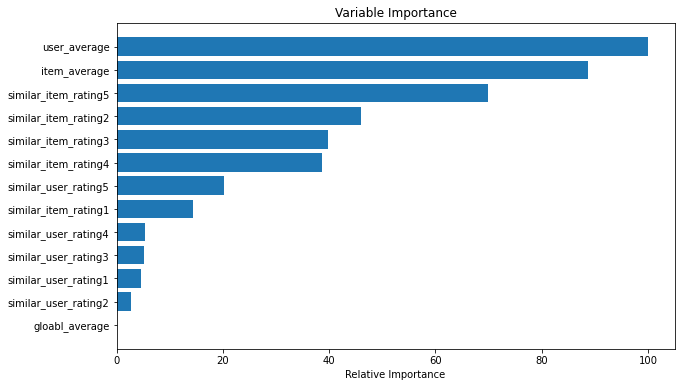

In [48]:
feature_importance = gb_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()